# Traceable Build

Embedded flash file build script, documentation, & tests.

## Generate universally unique identifier

Generate a UUID for this instance of the documentation, build, and tests.

> From Wikipedia, the free encyclopedia
A universally unique identifier (UUID) is a 128-bit number used to identify information in computer systems. The term globally unique identifier (GUID) is also used.

> When generated according to the standard methods, UUIDs are for practical purposes unique, without depending for their uniqueness on a central registration authority or coordination between the parties generating them, unlike most other numbering schemes. While the probability that a UUID will be duplicated is not zero, it is close enough to zero to be negligible.

> Thus, anyone can create a UUID and use it to identify something with near certainty that the identifier does not duplicate one that has already been, or will be, created to identify something else. **Information labeled with UUIDs by independent parties can therefore be later combined into a single database, or transmitted on the same channel, without needing to resolve conflicts between identifiers**.

> Adoption of UUIDs and GUIDs is widespread, with many computing platforms providing support for generating them, and for parsing their textual representation.

- https://en.wikipedia.org/wiki/Universally_unique_identifier

In [27]:
# Imports for build.
import glob
import uuid
import jinja2
import os
import re
import time
import datetime

In [28]:
build_uuid = str(uuid.uuid4())
build_uuid

'b9194007-953a-4fdb-b7ba-f368a0322d79'

In [19]:
# Checkpoints. Timestamps of what occured when.
checkpoints=list()
def checkpoint():
    now=datetime.datetime.utcnow().replace(tzinfo=datetime.timezone.utc).isoformat()
    checkpoints.append(now)
    print(now)
checkpoint()

2018-05-16T21:13:12.887542+00:00


### Build Environment

Build environment, for tracability. 

In [20]:
!uname -a

Linux m6700 4.15.0-13-generic #14-Ubuntu SMP Sat Mar 17 13:44:27 UTC 2018 x86_64 x86_64 x86_64 GNU/Linux


In [21]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04 LTS
Release:	18.04
Codename:	bionic


In [22]:
!hostname

m6700


In [23]:
!whoami

jed


#### Cleanup

Remove all previous sketches.

In [24]:
old_sketches = glob.glob("*.ino")
for old_sketch in old_sketches:
    print("Deleting: {}".format(old_sketch))
    os.unlink(old_sketch)

## Source Code

Source code template for the flash file.

In [32]:
arduino_template_str = """
unsigned long BAUD = {{ baud }};
unsigned long DELAY = {{ delay }};
char BUILD_UUID[] = "{{ build_uuid }}";

unsigned long arbitration_id = 0x0;
unsigned long time_millis = 0b0;
unsigned long timestamp = 0x0;

uint8_t counter8 = 0x00;
uint16_t counter16 = 0x0000;
uint32_t counter32 = 0x00000000;

// Arduino Setup
void setup() {
Serial.begin(BAUD);
Serial.print("Build UUID: ");
Serial.println(BUILD_UUID);

// Start of frame
Serial.write(0xAA);

// Timestamp
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// DLC
Serial.write(0x00);

// Arbitration ID
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// End of frame
Serial.write(0xBB);
return; 
}

// Arduino Main Loop
void loop() {

/* Begin timestamp data packet */
time_millis = millis();
// Start of frame
Serial.write(0xAA);

// Timestamp
timestamp = time_millis;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)timestamp>>shift&0b11111111);
}

// DLC
Serial.write(0x04);
// Arbitration ID
arbitration_id=1;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)arbitration_id>>shift&0xFF);
}

// Payload
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)time_millis>>shift&0b11111111);
}

// End of Frame
Serial.write(0xBB);
/* End timestamp data packet */
}
"""
arduino_template = jinja2.Template(arduino_template_str)

In [34]:
checkpoint()

2018-05-16T21:15:34.163106+00:00


### Source Configuration

Configuration options for the flash file.

Can be read from ConfigParser, JSON, XML, Databases, etc.

In [133]:
sketch_cfg=dict()
sketch_cfg["baud"] = 115200
sketch_cfg["delay"]= 1000
sketch_cfg["build_uuid"]=build_uuid

## Generated Source Code

Source code for the build:

In [134]:
arduino_sketch = (arduino_template.render(**sketch_cfg))
print(arduino_sketch)
sketch_file = "{}.ino".format(build_uuid)
with open(sketch_file, "w") as fid:
    fid.write(arduino_sketch)


unsigned long BAUD = 115200;
unsigned long DELAY = 1000;
char BUILD_UUID[] = "b9194007-953a-4fdb-b7ba-f368a0322d79";

unsigned long arbitration_id = 0x0;
unsigned long time_millis = 0b0;
unsigned long timestamp = 0x0;

uint8_t counter8 = 0x00;
uint16_t counter16 = 0x0000;
uint32_t counter32 = 0x00000000;

// Arduino Setup
void setup() {
Serial.begin(BAUD);
Serial.print("Build UUID: ");
Serial.println(BUILD_UUID);

// Start of frame
Serial.write(0xAA);

// Timestamp
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// DLC
Serial.write(0x00);

// Arbitration ID
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// End of frame
Serial.write(0xBB);
return; 
}

// Arduino Main Loop
void loop() {

/* Begin timestamp data packet */
time_millis = millis();
// Start of frame
Serial.write(0xAA);

// Timestamp
timestamp = time_millis;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)timestamp>>shift&0b11111111);
}

// 

## Formatting.

Format the sketch to adhere to LLVM style guidelines.

In [135]:
import subprocess
subprocess.check_output(["clang-format-6.0", "-style=LLVM", "-i", sketch_file])

b''

Cleaned source code, formated with LLVM style guidelines.

In [136]:
with open(sketch_file, "rb") as fid:
    arduino_sketch_formatted = fid.read()    
print(arduino_sketch_formatted.decode("UTF-8"))


unsigned long BAUD = 115200;
unsigned long DELAY = 1000;
char BUILD_UUID[] = "b9194007-953a-4fdb-b7ba-f368a0322d79";

unsigned long arbitration_id = 0x0;
unsigned long time_millis = 0b0;
unsigned long timestamp = 0x0;

uint8_t counter8 = 0x00;
uint16_t counter16 = 0x0000;
uint32_t counter32 = 0x00000000;

// Arduino Setup
void setup() {
  Serial.begin(BAUD);
  Serial.print("Build UUID: ");
  Serial.println(BUILD_UUID);

  // Start of frame
  Serial.write(0xAA);

  // Timestamp
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);

  // DLC
  Serial.write(0x00);

  // Arbitration ID
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);

  // End of frame
  Serial.write(0xBB);
  return;
}

// Arduino Main Loop
void loop() {

  /* Begin timestamp data packet */
  time_millis = millis();
  // Start of frame
  Serial.write(0xAA);

  // Timestamp
  timestamp = time_millis;
  for (char shift = 0; shift < 32; shift += 8) {
  

## Traceability

Checksum of the formatted source code, before compilation. Add to blockchain for an immutable proof of existence when it was generated, for tracability.

In [137]:
import hashlib
for algo in hashlib.algorithms_guaranteed:
    sketch_hash = getattr(hashlib, algo)(arduino_sketch_formatted)
    try:
        print("{}: {}".format(algo, sketch_hash.hexdigest()))
    except:
        pass

sha384: 3ef6fa5db7f6831af1988f2c320fb08cf99668021ebf781c1f1c63dcbe6c15815ad13c66c083e635bfd4a76f467aabc4
sha3_256: fdd84a10a856f81d5f65d9974fa4adad4700ae33dd2fd05dabc2eee505137e06
sha512: f58ac69b1efa71de1cff473eca5f139d0cdf073d36d8204719c3e4f6b86187774a67d44ffacc148a95f1843026591b0c6a15c86c2f9f659d69e48da8cfd6f103
blake2s: 7aaa23baebd00d2bad44f6eb2b1706efb035aca5962b930505c078063145ef75
sha3_512: 62a50aade1a2cdb617ec695bb10ea9aa9ae6567d6af10b30aaae4633e6f307cc79442c758cea00b7cc395a217a918012bcfcf0a1a72935e0bb2b928dbda06912
blake2b: bee1bd140f19869416994e9c662a63e81e50999c65df8c2894413b7f1a2722529b33b4b354e6588eea4e0f2ec6e061b6f888805de370a607b717a187d61c1515
sha3_384: 3e6da7c22e68adfcb4e28542950064d5d0063e96eccb1636df2ed445a6c7ae62fa06b71a212d8457a3eeb7f1863e2f88
sha1: 85867debcf83db58fa71cd950871ed20fa3800cd
sha224: 34e6f34fba59dc61a6fd7fd3b16151ef87af9a80c21d3473c3957b60
sha3_224: 1ffb4931cfca2a3f2ed20ad758c089506aeca98f027b0872ed096486
sha256: 161066086288cc01c5169e50ad17a388981b46

In [138]:
checkpoint()

2018-05-16T21:32:42.973561+00:00


# Build Process

## Build & Upload Flash File

In [139]:
import serial
import time

In [140]:
try:
    stdout = subprocess.check_output(["make", "upload"]).decode()
    print(stdout)
except subprocess.CalledProcessError as err:
    print("Build Failed:")
    print(err)
except:
    raise

-------------------------
Arduino.mk Configuration:
- [AUTODETECTED]       CURRENT_OS = LINUX 
- [AUTODETECTED]       ARDUINO_DIR = /usr/share/arduino 
- [COMPUTED]           ARDMK_DIR = /projects/arduino_IO/arduino_make (relative to Common.mk)
- [AUTODETECTED]       ARDUINO_VERSION = 105 
- [DEFAULT]            ARCHITECTURE =  
- [DEFAULT]            ARDMK_VENDOR = arduino 
- [AUTODETECTED]       ARDUINO_PREFERENCES_PATH = /mnt/ubuntu1604_2/home/jed/.arduino/preferences.txt 
- [AUTODETECTED]       ARDUINO_SKETCHBOOK = /mnt/ubuntu1604_2/home/jed/sketchbook (from arduino preferences file)
- [BUNDLED]            AVR_TOOLS_DIR = /usr/share/arduino/hardware/tools/avr (in Arduino distribution)
- [COMPUTED]           ARDUINO_LIB_PATH = /usr/share/arduino/libraries (from ARDUINO_DIR)
- [COMPUTED]           ARDUINO_VAR_PATH = /usr/share/arduino/hardware/arduino//variants (from ARDUINO_DIR)
- [COMPUTED]           BOARDS_TXT = /usr/share/arduino/hardware/arduino//boards.txt (from ARDUINO_DIR)
- 

In [141]:
checkpoint()

2018-05-16T21:32:52.742076+00:00


## Build Process Tests

Make sure that all serial ports from the build and upload process are the same.

In [142]:
serial_ports = re.compile("(/dev/ttyUSB[\d]+)").findall(stdout)
serial_ports

['/dev/ttyUSB2', '/dev/ttyUSB2', '/dev/ttyUSB2']

In [143]:
for i in range(len(serial_ports)-1):
    assert (serial_ports[i] == serial_ports[i+1])

In [144]:
checkpoint()

2018-05-16T21:32:52.760841+00:00


# Flashfile Testing 

V&V on the flashfile that was just built.

In [145]:
import serial
import time

In [146]:
ser = serial.Serial(
    port=serial_ports[0], baudrate=sketch_cfg["baud"],
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=10,
    xonxoff=0,
    rtscts=0
)

In [147]:
checkpoint()

2018-05-16T21:32:52.776335+00:00


### Build & Flash UUID verification

Assert that the UUID generated from the build script is the same one that is being reported back from the HIL flash file.

In [148]:
ser.setDTR(False) # Drop DTR
time.sleep(1)   # Read somewhere that 22ms is what the UI does.
ser.flushInput()
ser.flushOutput()
ser.flush()
ser.setDTR(True)  # UP the DTR back
header = ser.readline()
header

b'Build UUID: b9194007-953a-4fdb-b7ba-f368a0322d79\r\n'

In [149]:
header_uuid = header.split(b"UUID:")[1].strip().decode("UTF-8")

In [150]:
build_uuid

'b9194007-953a-4fdb-b7ba-f368a0322d79'

In [151]:
header_uuid

'b9194007-953a-4fdb-b7ba-f368a0322d79'

In [152]:
assert build_uuid == header_uuid

In [153]:
checkpoint()

2018-05-16T21:32:55.276842+00:00


## Packet validation.

Test that the CAN over Serial packets are being sent correctly.

Check that the configuration values also match.

In [154]:
ser.read_until(b"\xAA")
for x in range(10):
    packet = ser.read_until(b"\xBB")
    print(packet)

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbb'
b'\xaa\x01\x00\x00\x00\x04\x01\x00\x00\x00\x01\x00\x00\x00\xbb'
b'\xaa\x01\x00\x00\x00\x04\x01\x00\x00\x00\x01\x00\x00\x00\xbb'
b'\xaa\x02\x00\x00\x00\x04\x01\x00\x00\x00\x02\x00\x00\x00\xbb'
b'\xaa\x03\x00\x00\x00\x04\x01\x00\x00\x00\x03\x00\x00\x00\xbb'
b'\xaa\x04\x00\x00\x00\x04\x01\x00\x00\x00\x04\x00\x00\x00\xbb'
b'\xaa\x06\x00\x00\x00\x04\x01\x00\x00\x00\x06\x00\x00\x00\xbb'
b'\xaa\x07\x00\x00\x00\x04\x01\x00\x00\x00\x07\x00\x00\x00\xbb'
b'\xaa\x08\x00\x00\x00\x04\x01\x00\x00\x00\x08\x00\x00\x00\xbb'
b'\xaa\t\x00\x00\x00\x04\x01\x00\x00\x00\t\x00\x00\x00\xbb'


In [155]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\x0b\x00\x00\x00\x04\x01\x00\x00\x00\x0b\x00\x00\x00\xbb'

In [156]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\x0c\x00\x00\x00\x04\x01\x00\x00\x00\x0c\x00\x00\x00\xbb'

In [157]:
packet[1:5]

b'\x0c\x00\x00\x00'

In [158]:
timestamp_raw = packet[1:5]
timestamp_raw

b'\x0c\x00\x00\x00'

In [159]:
int.from_bytes(timestamp_raw, 'little')

12

In [160]:
int.from_bytes(timestamp_raw, 'big')

201326592

In [161]:
timestamp = int.from_bytes(timestamp_raw, 'little')
timestamp

12

In [162]:
sof = packet[0]
sof

170

In [163]:
int.from_bytes(b'\xAA', 'little')

170

In [164]:
int.from_bytes(b'\xAA', 'big')

170

In [165]:
assert sof == int.from_bytes(b'\xAA', 'little')

In [166]:
dlc = packet[5]
dlc

4

In [167]:
arbitration_id_raw = packet[6:10]
arbitration_id_raw

b'\x01\x00\x00\x00'

In [168]:
int.from_bytes(arbitration_id_raw, 'little')

1

In [169]:
int.from_bytes(arbitration_id_raw, 'big')

16777216

In [170]:
data = packet[11]
data 

0

In [171]:
sketch_cfg

{'baud': 115200,
 'delay': 1000,
 'build_uuid': 'b9194007-953a-4fdb-b7ba-f368a0322d79'}

In [172]:
header_uuid

'b9194007-953a-4fdb-b7ba-f368a0322d79'

In [173]:
sketch_cfg["build_uuid"]

'b9194007-953a-4fdb-b7ba-f368a0322d79'

In [174]:
assert str(header_uuid) == header_uuid

In [175]:
assert str(sketch_cfg["build_uuid"]) == sketch_cfg["build_uuid"]

In [176]:
assert header_uuid == sketch_cfg["build_uuid"]

In [177]:
ser.close()

# python-can testing

Validate and verify that ``python-can`` is decoding the packets correctly.

In [178]:
import can
can.__version__

'2.1.0'

In [179]:
bus_cfg = dict()
bus_cfg["bustype"] = "serial"
bus_cfg["channel"]=serial_ports[0]
bus_cfg["bitrate"]=115200

bus = can.interface.Bus(**bus_cfg)   
bus.ser.read_until(b"\xBB")

b'\x00\x00\x04\x01\x00\x00\x00\x8f\t\x00\x00\xbb'

In [180]:
packet = bus.recv()
packet

can.Message(timestamp=2.448, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x90, 0x9, 0x0, 0x0])

In [181]:
packet.timestamp

2.448

In [182]:
packet.arbitration_id

1

In [183]:
packet.dlc

4

In [184]:
packet.data

bytearray(b'\x90\t\x00\x00')

In [185]:
int.from_bytes(packet.data, 'little')

2448

In [186]:
int.from_bytes(packet.data, 'big')

2416508928

In [187]:
packet.timestamp

2.448

In [188]:
packets = list()
while len(packets)<100:
    packet = bus.recv()
    if packet is None:
        time.sleep(sketch_cfg["delay"])
    packets.append(packet)

In [189]:
packets

[can.Message(timestamp=2.449, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x91, 0x9, 0x0, 0x0]),
 can.Message(timestamp=2.451, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x93, 0x9, 0x0, 0x0]),
 can.Message(timestamp=2.452, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x94, 0x9, 0x0, 0x0]),
 can.Message(timestamp=2.453, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x95, 0x9, 0x0, 0x0]),
 can.Message(timestamp=2.454, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x96, 0x9, 0x0, 0x0]),
 can.Message(timestamp=2.456, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x98, 0x9, 0x0, 0x0]),
 can.Message(timestamp=2.457, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_i

In [190]:
class Data(object):
    def __init__(self):
        pass
data = Data()

In [191]:
data.time = [packet.timestamp for packet in packets]
data.time[:10]

[2.449, 2.451, 2.452, 2.453, 2.454, 2.456, 2.457, 2.458, 2.459, 2.461]

In [192]:
data.values = [int.from_bytes(packet.data, 'little') for packet in packets]
data.values[:10]

[2449, 2451, 2452, 2453, 2454, 2456, 2457, 2458, 2459, 2461]

In [193]:
data.time[0]

2.449

In [194]:
data.values[0]

2449

In [195]:
assert data.time[0]*1000 == data.values[0]

## Visual Test

Plot of data. Data is increasing linearly.

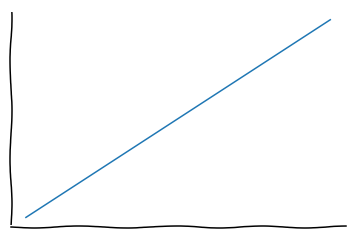

In [197]:
import matplotlib.pyplot as plt
plt.xkcd()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(data.time, data.values)

# Appendices

## Python Module Versions

In [198]:
!pip freeze

backcall==0.1.0
bleach==2.1.3
cycler==0.10.0
decorator==4.3.0
entrypoints==0.2.3
html5lib==1.0.1
ipykernel==4.8.2
ipython==6.4.0
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
kiwisolver==1.0.1
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
nbconvert==5.3.1
nbformat==4.4.0
notebook==5.5.0
numpy==1.14.3
pandas==0.23.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
pkg-resources==0.0.0
prompt-toolkit==1.0.15
ptyprocess==0.5.2
Pygments==2.2.0
pyparsing==2.2.0
pyserial==3.4
python-can==2.1.0
python-dateutil==2.7.3
pytz==2018.4
pyzmq==17.0.0
qtconsole==4.3.1
scipy==1.1.0
seaborn==0.8.1
Send2Trash==1.5.0
simplegeneric==0.8.1
six==1.11.0
terminado==0.8.1
testpath==0.3.1
tornado==5.0.2
traitlets==4.3.2
wcwidth==0.1.7
webencodings==0.5.1
widgetsnbextension==3.2.1
